In [1]:
import pandas as pd
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt


def get_monthly_stock_data(symbol, api_key):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full"
    response = requests.get(url)
    data = response.json()
    # Extract the time series data and convert it to a DataFrame
    time_series_key = 'Time Series (Daily)'
    df = pd.DataFrame(data[time_series_key]).T
    # df['Date'] = df.index
    # df.reset_index(drop = True, inplace= True)
    df.columns = ["Open", "High", "Low", "Close", "Volume"]

    return df

# Example usage
api_key = '93HDEE8UFKUO8AJ8'
df_amazon = get_monthly_stock_data('AMZN', api_key)



In [2]:
# Convert index to datetime and filter for the last month
def get_dat():
  df_amazon.index = pd.to_datetime(df_amazon.index)
  one_month_ago = datetime.datetime.now() - datetime.timedelta(days = 1.5*365)
  dat = df_amazon[df_amazon.index > one_month_ago]
  dat = dat.copy()
  dat['Date'] = dat.index
  dat.index = dat.pop('Date')
  dat = dat[['Close']]
  dat['Close'] = dat['Close'].astype('float64')
  dat = dat[::-1]
  return dat


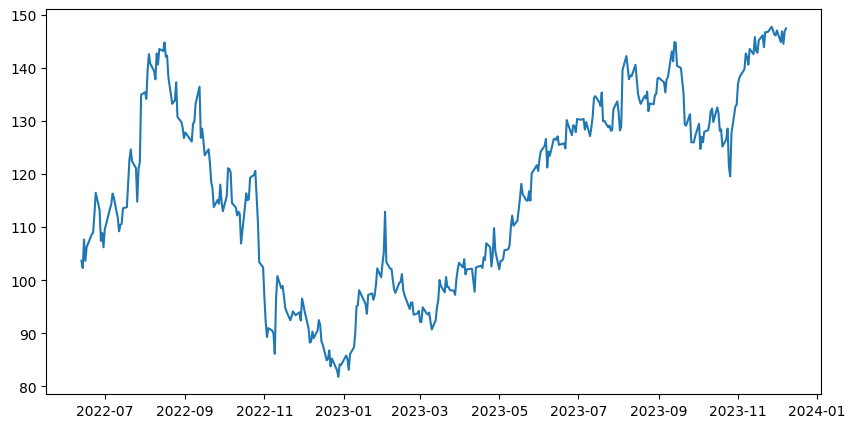

In [3]:
#Lets take a look at our closing prices
dat = get_dat()
plt.figure(figsize = (10, 5))
plt.plot(dat.index, dat['Close'])
plt.show()

In [4]:
def str_dt(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n = 3):

  a = len(dataframe) / 3
  b = a - np.fix(a)

  if b != 0:
    first_date = str_dt(first_date_str) + datetime.timedelta(days = 1)
    a = (len(dataframe) + 1) / 3
    b = a - np.fix(a)

    if b != 0:
      first_date = str_dt(first_date_str) + datetime.timedelta(days = 2)
      a = (len(dataframe) + 2) / 3
      b = (a) - np.fix(a)

      if b != 0:
        first_date = str_dt(first_date_str) + datetime.timedelta(days = 3)
        a = (len(dataframe) + 3) / 3
        b = (a) - np.fix(a)

        if b != 0:
          return 'Something went wrong with the date ranges'


  # Converting our data from strings to dates
  last_date = str_dt(last_date_str)

  # Setting a target date
  target_date = first_date

  dates = []
  X, Y = [], []

  # Create loop condition
  stop = False

  while True:


    # We are going to select all values till the target date, and then select the last 4
    dat_subset = dataframe.loc[:target_date].tail(4)

    # Those last 4 values are going to become an array
    values = dat_subset['Close'].to_numpy()


    # Set all the values except the last one to x (our training)
    # Set the last value to y the value of stock at the date
    x, y = values[:-1], values[-1]


    # Append our current date
    dates.append(target_date)

    # Append the values that will become our training data
    X.append(x)


    # Append the value that corresponds to our current day
    Y.append(y)


    # Look a week later from the current time
    next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days = 7)]


    # We grab the time of our next data point to look back 3 days
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day

    next_date = datetime.datetime(day = int(day), month = int(month), year = int(year))

    if stop:
      break

    target_date = next_date


    if target_date == last_date:
      stop = True



    # Create our dataframe
  ret_df = pd.DataFrame({})

    # Add in our dates
  ret_df['Target Date'] = dates

    # Transform x into an np array
  X = np.array(X)
  print(X)
    # We loop through each value in x and assign them as data that represents
    # value for each day until our target day
  for i in range(0, n):
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y


  return ret_df

start_date = dat.index[0] + datetime.timedelta(days = 3)
start_date = str(start_date.to_numpy()).split('T')[0]
end_date = str(dat.index[-1].to_numpy()).split('T')[0]
windowed_df = df_to_windowed_df(dat, start_date, end_date)
windowed_df

[[102.31 107.67 103.66]
 [103.66 106.22 108.68]
 [106.22 108.68 108.95]
 ...
 [147.03 144.84 146.88]
 [144.84 146.88 144.52]
 [146.88 144.52 146.88]]


,Target Date,Target-3,Target-2,Target-1,Target
0,2022-06-18,102.31,107.67,103.66,106.22
1,2022-06-22,103.66,106.22,108.68,108.95
2,2022-06-23,106.22,108.68,108.95,112.44
3,2022-06-24,108.68,108.95,112.44,116.46
4,2022-06-27,108.95,112.44,116.46,113.22
...,...,...,...,...,...
366,2023-12-04,146.32,146.09,147.03,144.84
367,2023-12-05,146.09,147.03,144.84,146.88
368,2023-12-06,147.03,144.84,146.88,144.52
369,2023-12-07,144.84,146.88,144.52,146.88


In [5]:
def windowed_df_to_date_X_y(df):
  df_as_np = df.to_numpy()

  dates = df_as_np[:, 0]

  input_matrix = df_as_np[:, 1:-1]
  X = input_matrix.reshape((len(dates), input_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((371,), (371, 3, 1), (371,))

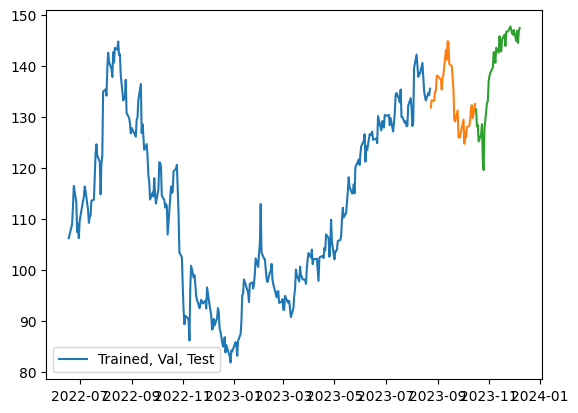

In [6]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Trained, Val, Test'])
plt.show()



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['mean_absolute_error'])


model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
10/10 [==============================] - 9s 74ms/step - loss: 12797.8594 - mean_absolute_error: 111.9116 - val_loss: 17681.7949 - val_mean_absolute_error: 132.8548
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 12682.4727 - mean_absolute_error: 111.3963 - val_loss: 17517.8145 - val_mean_absolute_error: 132.2362
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 12516.0264 - mean_absolute_error: 110.6468 - val_loss: 17287.5117 - val_mean_absolute_error: 131.3625
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 12309.5205 - mean_absolute_error: 109.7050 - val_loss: 17007.6367 - val_mean_absolute_error: 130.2927
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 12016.3379 - mean_absolute_error: 108.3570 - val_loss: 16555.4121 - val_mean_absolute_error: 128.5451
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 11489.3662 - mean_absolute_error: 105.8536 - val

10/10 [==============================] - 1s 3ms/step


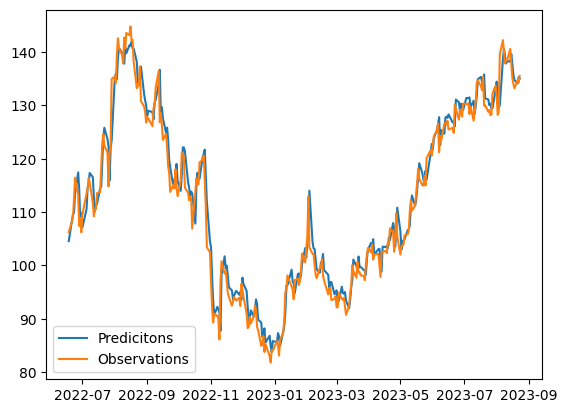

In [8]:
trained_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, trained_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Predicitons', 'Observations'])

2/2 [==============================] - 0s 6ms/step


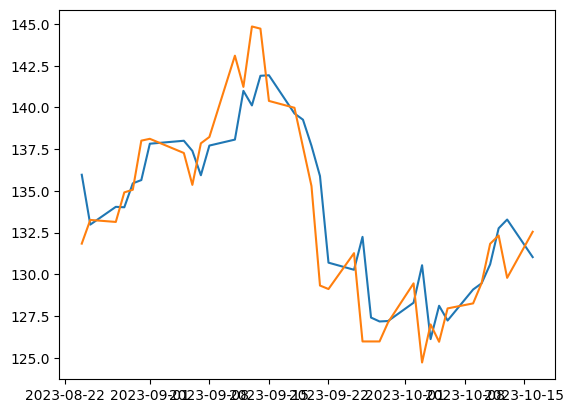

In [9]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)


2/2 [==============================] - 0s 6ms/step


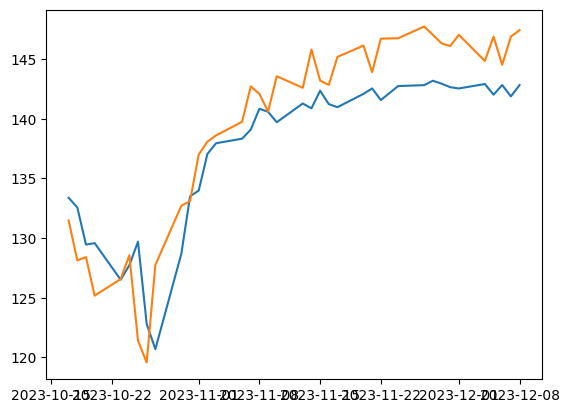

In [10]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

2/2 [==============================] - 0s 9ms/step


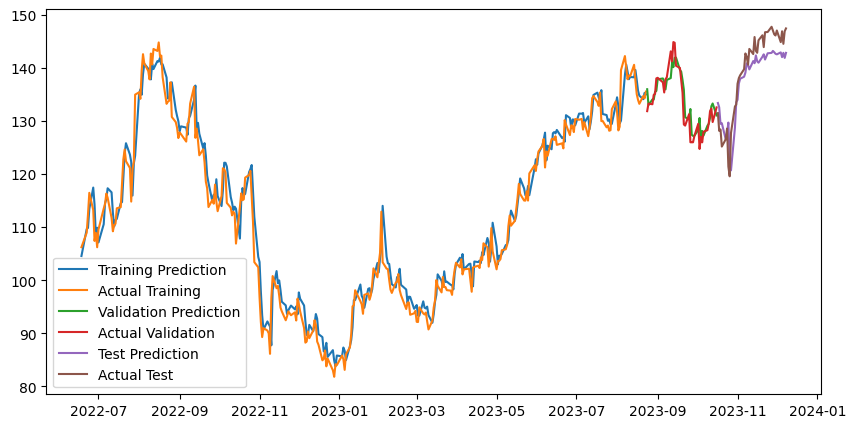

In [11]:
fig, ax = plt.subplots(figsize = (10, 5))

trained_predictions = model.predict(X_train).flatten()
ax.plot(dates_train, trained_predictions, label = 'Training Prediction')
ax.plot(dates_train, y_train, label = 'Actual Training')

val_predictions = model.predict(X_val).flatten()
ax.plot(dates_val, val_predictions, label = 'Validation Prediction')
ax.plot(dates_val, y_val, label = 'Actual Validation')

test_predictions = model.predict(X_test).flatten()
ax.plot(dates_test, test_predictions, label = 'Test Prediction')
ax.plot(dates_test, y_test, label = 'Actual Test')
plt.legend()

1/1 [==============================] - 0s 39ms/step


141.86308